In [1]:
using Pkg
Pkg.activate("/Users/ryansenne/Documents/GitHub/SSM")
# Pkg.activate("/home/ryansenne/PycharmProjects/ssm_julia/")

  Activating project at `\Users\ryansenne\Documents\GitHub\SSM`


In [2]:
include("/Users/ryansenne/Documents/Github/SSM//src/SSM.jl")
# include("/home/ryansenne/PycharmProjects/ssm_julia/src/SSM.jl")
using LinearAlgebra
using Plots
using Distributions
using Random
using .SSM
using StatsBase

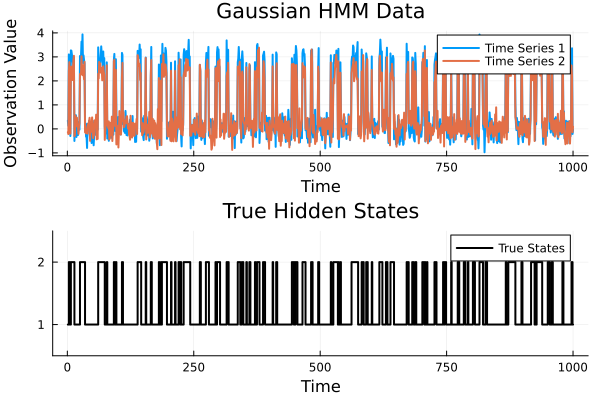

In [4]:
# generate data from a Gaussian HMM model
Random.seed!(1234)

A = [0.9 0.1; 0.3 0.7]
means = [[0.0, 0.0], [3.0, 2.5]]
covs = [
    [0.1 0.0; 0.0 0.1],  # Covariance matrix for state 1
    [0.1 0.0; 0.0 0.1],  # Covariance matrix for state 2   # Covariance matrix for state 3
]
emissions_models = [GaussianEmission(mean, cov) for (mean, cov) in zip(means, covs)]

hmm = GaussianHMM(A, emissions_models, [0.5, 0.5], 2, 2)

states, observations = SSM.sample(hmm, 1000)

plot(observations[:, 1], observations[:, 2], seriestype=:scatter, legend=false)

function plot_hmm_data(observations, states)
    # Create a new plot with the first time series
    p1 = plot(observations[:, 1], label="Time Series 1", legend=:topright, title="Gaussian HMM Data", xlabel="Time", ylabel="Observation Value", linewidth=2)
    # Add the second time series to the same plot
    plot!(observations[:, 2], label="Time Series 2", linewidth=2)

    # Plot the true states below
    p2 = plot(states, line=:steppost, label="True States", title="True Hidden States", xlabel="Time", ylims=(0.5, 2.5), yticks=[1, 2], linewidth=2, color=:black)

    # Display the plots vertically aligned
    plot(p1, p2, layout=(2, 1), link=:x)
end

plot_hmm_data(observations, states)

In [5]:
A = [0.2 0.8; 0.5 0.5];
Pi = [0.5, 0.5];

U1 = [-5, -5];
U2 = [-3, -3];
Sigma1 = [1 0; 0 1];
Sigma2 = [0.5 0; 0 0.5];
emissions_models = [GaussianEmission(mean, cov) for (mean, cov) in zip([U1, U2], [Sigma1, Sigma2])]

hmm = GaussianHMM(A, emissions_models, [0.5, 0.5], 2, 2)

model = GaussianHMM(observations, 2)

GaussianHMM{GaussianEmission}([0.4140624518716696 0.5859375481283303; 0.7772351160345606 0.2227648839654394], GaussianEmission[GaussianEmission([1.3282837871251076, 1.0176090393609667], [1.934979704425176 1.6670431586174486; 1.6670431586174486 1.594872170601647]), GaussianEmission([-0.31115371322246027, 0.00403700579715374], [0.03195947905550192 0.0033361409853051296; 0.0033361409853051296 0.09880941239346905])], [0.010266023624404175, 0.9897339763755958], 2, 2)

In [6]:
baumWelch!(model, observations, 100)

2049.33069951655
1810.732903446582
1626.3729497419995
1423.2247385788621
1254.9078557889636
1064.5237795901037
968.6295071567581
968.6223269047744
968.6223269047744


In [11]:
model.B

2-element Vector{GaussianEmission}:
 GaussianEmission([2.9923341517861504, 2.50195079658179], [0.09656420872164403 0.003194061729931824; 0.003194061729931824 0.09615373060427639])
 GaussianEmission([-0.010286481591723422, 0.01112437974339559], [0.10283443554969486 -6.895035427589282e-6; -6.895035427589282e-6 0.106933646895876])

In [16]:
using DataFrames
using CSV
CSV.write("hmm_observations.csv", DataFrame(observations, :auto), writeheader=false)

"hmm_observations.csv"

In [3]:
using CSV
using DataFrames

# import old faithful data
old_faithful = CSV.read("/Users/ryansenne/PycharmProjects/NV_States_GLM_HMM/HMM_Bishop/faithful.csv", DataFrame)

# set up a variable for the HMM
X = Matrix{Float64}(old_faithful[:, [:waiting, :eruptions]])
#  zscore the data
X = (X .- mean(X, dims=1)) ./ std(X, dims=1)

# Set up initial parameters
A = [0.2 0.8; 0.5 0.5];
Pi = [0.5, 0.5];

U1 = [3, -5];
U2 = [-3, -3];
Sigma1 = [1 0; 0 1];
Sigma2 = [0.5 0; 0 0.5];

hmm = SSM.GaussianHMM(A, [GaussianEmission(U1, Sigma1), GaussianEmission(U2, Sigma2)], Pi, 2, 2)
# hmm = SSM.GaussianHMM(X, 2)
baumWelch!(hmm, X, 100)


4584.525833216941
386.31328375215315
370.53873776436336
361.91290816951516
357.82735030522963
353.4949495745846
350.79384285209557
350.3325956007971
350.30025963978903
350.29900498143144
350.2989624526667
350.2989610442504
350.29896099780433


In [4]:
a, c = SSM.forward(hmm, X)
b = SSM.backward(hmm, X, c)

2×272 Matrix{Float64}:
 0.5        0.254093  0.500001   …  0.254093  0.5        0.254093  0.5
 0.0590908  0.5       0.0590929     0.5       0.0590908  0.5       0.5